In [73]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils import data
from torchsummary import summary
    
def load_CIFAR10_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    train_set = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                             download=True, transform=transform)
    train_set, validation_set = data.random_split(train_set,
                                                  (int(len(train_set) * 0.9), int(len(train_set) * 0.1)))
    test_set = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                            download=True, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=2500,
                                   shuffle=True, num_workers=0)
    validation_loader = data.DataLoader(validation_set, batch_size=2500,
                                        shuffle=True, num_workers=0)
    test_loader = data.DataLoader(test_set, batch_size=2500,
                                  shuffle=True, num_workers=0)
    return train_loader, validation_loader, test_loader, test_set.classes


def load_CIFAR100_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    train_set = torchvision.datasets.CIFAR100(root='./dataset', train=True,
                                              download=True, transform=transform)
    train_set, validation_set = data.random_split(train_set, (int(len(train_set) * 0.9), int(len(train_set) * 0.1)))
    test_set = torchvision.datasets.CIFAR100(root='./dataset', train=False,
                                             download=True, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=2500,
                                   shuffle=True, num_workers=0,
                                   pin_memory=True)
    validation_loader = data.DataLoader(validation_set, batch_size=2500,
                                        shuffle=True, num_workers=0,
                                        pin_memory=True)
    test_loader = data.DataLoader(test_set, batch_size=2500,
                                  shuffle=True, num_workers=0,
                                  pin_memory=True)

    return train_loader, validation_loader, test_loader, test_set.classes


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def accuracy_plot(accuracies, TEST):
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.xlabel("epoch")
    plt.ylabel("accuracy\n(%)").set_rotation(0)

    if (TEST):
        plt.legend(["train", "test"])
    else:
        plt.legend(["train", "validation"])


def losses_plot(train_losses, losses, TEST):
    plt.plot(range(1, len(train_losses) + 1), train_losses)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel("epoch")
    plt.ylabel("loss").set_rotation(0)

    if (TEST):
        plt.legend(["train", "test"])
    else:
        plt.legend(["train", "validation"])


def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    correct = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        regularization_loss = 0.0
        for param in model.parameters():
            regularization_loss += torch.norm(param)
        loss = criterion(outputs, y) + LAMBDA * regularization_loss
        loss.backward()
        optimizer.step()
    return loss.item()


def validate(model, validation_loader, criterion, device, epoch):
    model.eval()
    vali_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in validation_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            vali_loss += criterion(outputs, y).item()
            outputs = F.softmax(outputs, dim=1)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    vali_loss /= len(validation_loader.dataset)
    vali_percentage = round(correct / len(validation_loader.dataset) * 100, 2)
    print(
        f"Epoch:{epoch} Validation loss: {vali_loss:0.6f}, Validation Accuracy:{correct}/{len(validation_loader.dataset)} ({vali_percentage}%)"
    )
    return vali_percentage, vali_loss


def test(model, test_loader, criterion, device, epoch, classes, topk):
    model.eval()
#     class_correct = [0.0 for i in range(len(classes))]
#     class_total = [0.0 for i in range(len(classes))]
    
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            test_loss += criterion(outputs, y).item()
            outputs = F.softmax(outputs, dim=1)
            if (topk == 1):
                pred = outputs.argmax(dim=1, keepdim=True)
                correct_pred = pred.eq(y.view_as(pred))
                correct += correct_pred.sum().item()
#                 for i in range(len(y)):
#                     label = y[i].item()
#                     class_correct[label] += correct_pred[i].item()
#                     class_total[label] += 1
            else:
                _, pred = outputs.topk(topk, 1, True, True)
                correct_pred = pred.eq(y.view(-1, 1).expand_as(pred))
                correct += correct_pred.sum().item()
#                 for i in range(len(y)):
#                     label = y[i].item()
#                     class_correct[label] += correct_pred[i].sum().item()
#                     class_total[label] += 1
            
    test_percentage = round(correct / len(test_loader.dataset) * 100, 2)
    print(
        f"Epoch:{epoch} Test loss: {test_loss:0.6f}, Test Accuracy:{correct}/{len(test_loader.dataset)} ({test_percentage}%)"
    )
    return test_percentage, test_loss


class convLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, pooling_size, padding_size, dropout_rate):
        super(convLayer, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, padding=padding_size)
        self.pooling_size = pooling_size
        if self.pooling_size:
            self.pool = nn.MaxPool2d(pooling_size)
        self.bm = nn.BatchNorm2d(out_channel)
        self.drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bm(x)
        if self.pooling_size:
            x = self.pool(x)
        x = self.drop(x)
        return x


# https://discuss.pytorch.org/t/flatten-layer-of-pytorch-build-by-sequential-container/5983
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = convLayer(3, 64, 3, 2, 1, 0.3)
        self.conv2 = convLayer(64, 128, 3, 0, 1, 0.3)
        self.conv3 = convLayer(128, 256, 5, 2, 1, 0.3)
        self.conv4 = convLayer(256, 512, 5, 2, 1, 0.3)
        self.conv5 = convLayer(512, 512, 3, 0, 1, 0.4)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.flatten, self.fc1, self.fc2, self.fc3]
        self.activations = [False, False, False, False, False, False, True, True, True]
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            if activation:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x

class CIFAR100Model(nn.Module):
    def __init__(self):
        super(CIFAR100Model, self).__init__()
        self.conv1 = convLayer(3, 64, 3, 2, 1, 0.4)
        self.conv2 = convLayer(64, 128, 3, 0, 1, 0.4)
        self.conv3 = convLayer(128, 256, 5, 2, 2, 0.4)
        self.conv4 = convLayer(256, 512, 5, 2, 2, 0.4)
        self.conv5 = convLayer(512, 512, 1, 0, 0, 0.4)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(8192, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 100)
        self.layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.flatten, self.fc1, self.fc2, self.fc3]
        self.activations = [False, False, False, False, False, False, True, True, True]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            if activation:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x
    
def transfer_learning_resnet152(num_classes):
    model = torchvision.models.resnet152(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, num_classes),
    )
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters())
    return model, criterion, optimizer

In [57]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
train_loader, validation_loader, test_loader, classes = load_CIFAR10_data()
device

Files already downloaded and verified
Files already downloaded and verified


device(type='cuda', index=1)

In [ ]:
EPOCH = 60
TEST = True
LAMBDA = 0.03

model = CIFAR10Model()
summary(model, (3, 32, 32), device="cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

accuracies = []
train_losses = []
losses = []

for epoch in range(1, EPOCH + 1):
    loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_losses.append(loss)
    if not TEST:
        acc, loss = validate(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
    else:
        acc, loss = test(model, validation_loader, criterion, device, epoch, classes, 1)
        accuracies.append(acc)
        losses.append(loss)
plt.figure(1)
accuracy_plot(accuracies, TEST)
plt.figure(2)
losses_plot(train_losses, losses, TEST)
plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
           Dropout-4           [-1, 64, 16, 16]               0
         convLayer-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
           Dropout-8          [-1, 128, 16, 16]               0
         convLayer-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 14, 14]         819,456
      BatchNorm2d-11          [-1, 256, 14, 14]             512
        MaxPool2d-12            [-1, 256, 7, 7]               0
          Dropout-13            [-1, 256, 7, 7]               0
        convLayer-14            [-1, 25

In [ ]:
for epoch in range(1, EPOCH + 21):
    loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_losses.append(loss)
    if not TEST:
        acc,loss = validate(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
    else:
        acc, loss = test(model, validation_loader, criterion, device, epoch, classes, 1)
        accuracies.append(acc)
        losses.append(loss)
plt.figure(1)
accuracy_plot(train_accuracies, accuracies, TEST)
plt.figure(2)
losses_plot(train_losses, losses, TEST)
plt.show()

In [ ]:
accuracy_plot(accuracies, TEST)
plt.savefig("accuracies4.png")

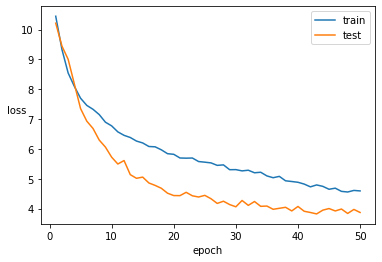

In [47]:
losses_plot(train_losses, losses, TEST)
plt.savefig("losses3.png")